In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

In [10]:
df = pd.read_csv('/content/df_merge_singkat.csv')
df.head()
df.describe()

,Luas_Hutan_ha,Jumlah_Emisi_2018,Jumlah_Emisi_2019,Jumlah_Emisi_2020,Jumlah_Emisi_2021,Jumlah_Emisi_2022,jumlah_Kebakaran_Hutan_2018,jumlah_Kebakaran_Hutan_2019,jumlah_Kebakaran_Hutan_2020,jumlah_Kebakaran_Hutan_2021,jumlah_Kebakaran_Hutan_2022
count,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,3.300000e+01,33.000000,33.000000,33.000000,33.000000,33.000000
mean,4.871445e+06,4.925906e+06,1.888034e+07,1.210152e+06,1.399890e+06,7.118399e+05,16019.361515,49718.151515,8946.090909,10823.909091,6197.696970
std,5.843812e+06,1.119043e+07,4.743872e+07,2.402171e+06,3.051293e+06,1.395136e+06,26607.325097,84507.158138,20585.732285,28814.354352,13391.834288
min,9.107727e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.313230e+06,3.675200e+04,2.815200e+05,3.057600e+04,1.095200e+04,1.953700e+04,331.670000,2133.000000,569.000000,385.000000,328.000000
50%,3.130946e+06,5.065430e+05,8.850180e+05,2.531080e+05,1.627700e+05,1.605070e+05,2421.900000,9552.000000,2344.000000,1588.000000,1620.000000
75%,5.503841e+06,2.557810e+06,6.646052e+06,1.623911e+06,1.028498e+06,8.584240e+05,15156.220000,60234.000000,7646.000000,5411.000000,4915.000000
max,2.787490e+07,4.355416e+07,2.161338e+08,1.242300e+07,1.465201e+07,6.936347e+06,98637.990000,336798.000000,114719.000000,137343.000000,70637.000000


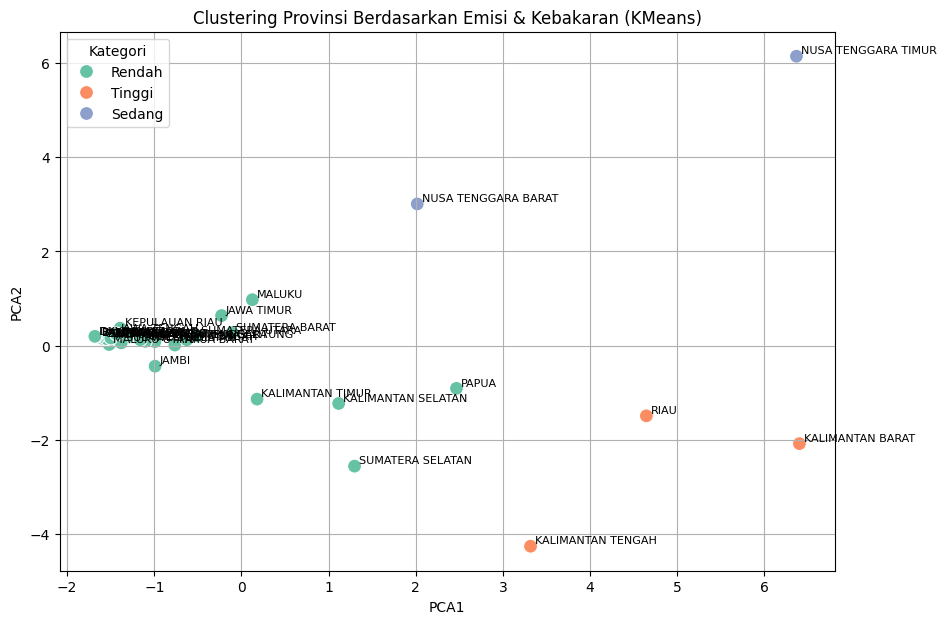

=== Hasil Kategori dan Skor Gabungan Tiap Provinsi ===
                     Provinsi  Cluster Kategori  Total_Emisi  Total_Kebakaran  \
0                      MALUKU        0   Rendah      7020795         89148.44   
1                MALUKU UTARA        0   Rendah       279160          3188.54   
2   KEPULAUAN BANGKA BELITUNG        0   Rendah      1620576          8122.67   
3                      BANTEN        0   Rendah         2557            11.00   
4                   GORONTALO        0   Rendah       223929          2411.65   
5                 PAPUA BARAT        0   Rendah      4165853          9573.50   
6                  JAWA BARAT        0   Rendah      1536838         19304.51   
7                       PAPUA        0   Rendah     15561003        249328.84   
8              SULAWESI UTARA        0   Rendah       371185          6125.39   
9            SUMATERA SELATAN        0   Rendah    163876994        362942.60   
10             KEPULAUAN RIAU        0   Rendah      1

In [11]:
# 3. Simpan nama provinsi, lalu hapus untuk proses clustering
provinsi = df['Provinsi']
X = df.drop(columns=['Provinsi'])

# 4. Standardisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. KMeans clustering (jumlah cluster = 3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# 6. Tambahkan hasil cluster ke DataFrame
df['Cluster'] = clusters

# 7. Hitung rata-rata tiap fitur per cluster
cluster_mean = df.drop(columns=['Provinsi'], errors='ignore').groupby('Cluster').mean()

# 8. Hitung total emisi & kebakaran per cluster
emisi_cols = ['Jumlah_Emisi_2018', 'Jumlah_Emisi_2019', 'Jumlah_Emisi_2020',
              'Jumlah_Emisi_2021', 'Jumlah_Emisi_2022']
kebakaran_cols = ['jumlah_Kebakaran_Hutan_2018', 'jumlah_Kebakaran_Hutan_2019',
                  'jumlah_Kebakaran_Hutan_2020', 'jumlah_Kebakaran_Hutan_2021',
                  'jumlah_Kebakaran_Hutan_2022']

cluster_mean['Total_Emisi'] = cluster_mean[emisi_cols].sum(axis=1)
cluster_mean['Total_Kebakaran'] = cluster_mean[kebakaran_cols].sum(axis=1)

# 9. Skor Gabungan
cluster_mean['Skor_Gabungan'] = cluster_mean['Total_Emisi'] + cluster_mean['Total_Kebakaran']

# 10. Mapping cluster ke kategori berdasarkan urutan Skor Gabungan
sorted_clusters = cluster_mean['Skor_Gabungan'].sort_values().index
label_map = {
    sorted_clusters[0]: 'Rendah',
    sorted_clusters[1]: 'Sedang',
    sorted_clusters[2]: 'Tinggi'
}
df['Kategori'] = df['Cluster'].map(label_map)

# ⬇ Menghitung total per provinsi
df['Total_Emisi'] = df[emisi_cols].sum(axis=1)
df['Total_Kebakaran'] = df[kebakaran_cols].sum(axis=1)
df['Skor_Gabungan'] = df['Total_Emisi'] + df['Total_Kebakaran']

# 11. Visualisasi hasil clustering pakai PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_viz = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_viz['Kategori'] = df['Kategori']
df_viz['Provinsi'] = df['Provinsi']

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_viz, x='PCA1', y='PCA2', hue='Kategori', palette='Set2', s=100)
for i in range(len(df_viz)):
    plt.text(df_viz['PCA1'][i]+0.05, df_viz['PCA2'][i]+0.05, df_viz['Provinsi'][i], fontsize=8)
plt.title('Clustering Provinsi Berdasarkan Emisi & Kebakaran (KMeans)')
plt.grid(True)
plt.show()

# 12. asil akhir (lengkap)
print("=== Hasil Kategori dan Skor Gabungan Tiap Provinsi ===")
print(df[['Provinsi', 'Cluster', 'Kategori', 'Total_Emisi', 'Total_Kebakaran', 'Skor_Gabungan']])